In [ ]:
import torch
import pandas as pd
import numpy as np
import pickle as pkl
import argparse
import yaml
from synflow_args_helper import synflow_parser_args
from gem_miner_args_helper import gem_miner_parser_args

In [ ]:
print("synflow config:", synflow_parser_args.config, "\nsynflow model:", synflow_parser_args.model, "\nsynflow data:", synflow_parser_args.dataset)
print(" ")
print("gemini config:", gem_miner_parser_args.config, "\ngemini model:", gem_miner_parser_args.arch, "\ngemini data:", gem_miner_parser_args.dataset)


In [ ]:
# change args helper manually 

# load yaml file
syn_yaml_txt = open('Configs/synflow_resnet20.yml').read()
gem_yaml_txt = open('/Users/tjarkdarius/Desktop/syngem_v3/Configs/gemini_resnet20_CIFAR_sparsity_1_44_unflagT.yml').read()

# override old args
syn_loaded_yaml = yaml.load(syn_yaml_txt, Loader=yaml.FullLoader)
gem_loaded_yaml = yaml.load(gem_yaml_txt, Loader=yaml.FullLoader)

synflow_parser_args.__dict__.update(syn_loaded_yaml)
gem_miner_parser_args.__dict__.update(gem_loaded_yaml)

In [ ]:
# show new configurations 
print("synflow config:", synflow_parser_args.config, "\nsynflow model:", synflow_parser_args.model, "\nsynflow data:", synflow_parser_args.dataset)
print(" ")
print("gemini config:", gem_miner_parser_args.config, "\ngemini model:", gem_miner_parser_args.arch, "\ngemini data:", gem_miner_parser_args.dataset)

In [ ]:
# after updating config files, we can create the mdoels
from Models.resnet_kaiming import resnet20 as gem_resnet20
from Models.lottery_resnet import resnet20 as syn_resnet20

In [ ]:
D = 20
W = 16
plan = [(W, D), (2*W, D), (4*W, D)]

syn_model = syn_resnet20(plan, 10)
gem_model = gem_resnet20()

In [ ]:
syn_model.load_state_dict(torch.load("/Users/tjarkdarius/Desktop/test_results/synflow_resnet20_cifar_seed_42_epochs_100_compr_05/model.pt", map_location=torch.device('cpu')))
gem_model.load_state_dict(torch.load("/Users/tjarkdarius/Desktop/test_results/hc_sparsity_1_44_unflagT/results_pruning_CIFAR10_resnet20_hc_iter_0_5_5_reg_L2_0_0001_sgd_cosine_lr_0_1_0_1_50_finetune_0_01_MAML_-1_10_fan_False_signed_constant_unif_width_1_0_seed_42_idx_None/model_after_finetune.pth", map_location=torch.device('cpu')))

In [ ]:
#syn_model.eval()

In [ ]:
#gem_model.eval()

In [ ]:
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [ ]:
lel = get_children(init_model)
lul = get_children(tuned_model)

In [ ]:
lel

In [ ]:
init_model.eval()

In [ ]:
list(init_model.children())

In [ ]:
lel

In [ ]:
lul[0].state_dict().keys()

In [ ]:
n , i = np.unique(lul[0].state_dict()['flag'].numpy().flatten()  , return_counts=True)
print(n)
print(i)

In [ ]:
all_zeros = 0
all_ones = 0
for i in range(len(lul)):
    try:
        n , i = np.unique(lul[i].state_dict()['flag'].numpy().flatten()  , return_counts=True)
        all_zeros += i[0]
        all_ones += i[1]
    except:
        pass
    
print(all_ones / all_zeros)

In [ ]:
gg = all_ones + all_zeros

In [ ]:
(all_ones / gg) * 100

# fuckin got it !
# weights dont matter
# flags do
# ratio of 0's and 1's in flag is the sparsity, NOT weights 
# how can i use this knowledge though ?
# --> 1. gain some structural information for CNN's ?
# --> 2. work with fully connected networks instead ? better architecture gain

# wait
# new idea
# look at distribution of 0's and 1's for each layer in model 
# where sparsity higher than average, the layer might be considered "not that important"
# and when many 1's, the layer might be important
# thus giving insight in structure and architecture of models
# since fully connected networks might suck 
# would be trained on mnist and I have to code everything
# since gem-miner people didnt put too much effort into it
# but still could make for a nice section in the BA
# first fc then (more difficult) CNN/RNN 
# fc look at structure "dot-wise"
# span network and see what is pruned where
# then in CNN/RNN section look at structure of kernels
# maybe use heatmap like Isabel 
# and also the layer wise distribution (need cool idea for graphic there)

In [ ]:
for i in range(len(lel)):
    try:
        lay = lel[i].state_dict()['flag']
        loy = lul[i].state_dict()['flag']
        
        kok = lay == loy
        
        print(all(kok.numpy().flatten()))
        
        
    except:
        print("Hm")
    

In [ ]:
first_layer_init = lel[10].state_dict()['weight']
first_layer_tuned = lul[10].state_dict()['weight']

In [ ]:
#first_layer_init

In [ ]:
#first_layer_tuned

In [ ]:
kok = first_layer_init == first_layer_tuned
all(kok.numpy().flatten())

# Weird that init model and tuned model are the same ?
# Look at accuracy by hand --> load cifar10 and test 
# Whats going on here ?
# Mayber saving wrong in script ?

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
batch_size = 4

normalize = transforms.Normalize(
            mean=[0.491, 0.482, 0.447],
            std=[0.247, 0.243, 0.262]
        )

transform_train = transforms.Compose(
                    [
                        transforms.RandomCrop(32, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        normalize,
                    ]
                )

transform_test = transforms.Compose(
                    [
                        transforms.ToTensor(),
                        normalize
                    ]
                )

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
dataiter = iter(testloader)

In [ ]:
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
img, labl = next(dataiter)

In [ ]:
img.size()

In [ ]:
img = torchvision.utils.make_grid(img)
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
test = np.transpose(npimg, (1, 2, 0))

In [ ]:
test.shape

In [ ]:
outputs = tuned_model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
outputs = init_model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

class get_images_cifar10(object):
    def __init__(self, batch_size: int = 1):
        self.batch_size = batch_size
        
    
        normalize = transforms.Normalize(
                    mean=[0.491, 0.482, 0.447],
                    std=[0.247, 0.243, 0.262]
                )

        transform_train = transforms.Compose(
                            [
                                transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize,
                            ]
                        )

        transform_test = transforms.Compose(
                            [
                                transforms.ToTensor(),
                                normalize
                            ]
                        )

        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                  shuffle=True, num_workers=1)

        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                 shuffle=False, num_workers=1)

        classes = ('plane', 'car', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        
        
        self.trainloader = trainloader
        self.testloader = testloader
        self.classes = classes
        
        self.get_new_images(output = False)
   
    
    def get_new_images(self, target: str = "random", output: bool = True):
        # get some random training images
        if target == "random":
            dataiter = iter(self.trainloader)
            images, labels = next(dataiter)

            self.images = images
            self.labels = labels
            
        elif target in self.classes:
            target_images = torch.zeros((self.batch_size, 3, 32, 32))
            counter = 0
            correct_label = None
            dataiter = iter(self.trainloader)

            while counter < self.batch_size:
                images, labels = next(dataiter)
                
                for i, j in enumerate(labels):
                    labl = self.classes[j]
                    
                    if target == labl:
                        if correct_label == None:
                            correct_label = j  
                        target_images[counter] = images[i]
                        counter += 1
                        
                        
            self.images = target_images
            self.labels = [correct_label] * self.batch_size
                
            
        
        if output:
            return self.images, self.labels
        
    
    
    def display(self):
        img = torchvision.utils.make_grid(self.images)
        
        img = img / 2 + 0.5     # unnormalize
        npimg = np.clip(img.numpy(), 0, 1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
        print('GroundTruth: ', ' '.join(f'{self.classes[self.labels[j]]:5s}' for j in range(self.batch_size)))
        
        
        

In [18]:
test = get_images_cifar10(batch_size = 4)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
test.get_new_images("cat", output = False)

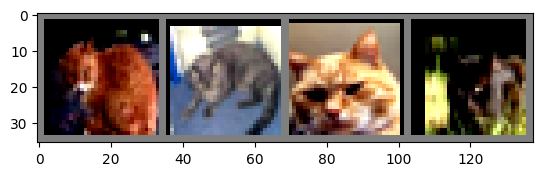

GroundTruth:  cat   cat   cat   cat  


In [26]:
test.display()

In [20]:
["yay"] * 4

['yay', 'yay', 'yay', 'yay']

# wtf geht hier ab ?
# tuned model acc in ordnung
# init komplett whack
# war zu erwarten aber nicht auf basis der weights 
# es sind doch alle weights gleich laut "analyse" ??!
# wtf

In [ ]:
def check_sparsity(model: torch.nn.Module, layers: int = None, single: bool = False):

    ## need doc string
    
    # get children
    each_layer = get_children(model)

    # declare empty sparsities dictionary
    sparsities = {}
    
    # declare counter variables
    all_zeros , all_ones = 0 , 0
    
    # check arguments, otherwise raise error
    if type(single) != bool:
        print("Single must be boolean")
        
    if layers != None and type(layers) == list:
        for i in layers:
            if type(i) != int:
                # maybe actually raise error instead of printing ?
                print("Layers must be None or (list of) integers")
                
            # already iterating over layers, why not use ?
            # because dont know if single or not ?
            
            if single:
                _ , counts = np.unique(each_layer[i].state_dict()['flag'].numpy().flatten()  , return_counts=True)
                calc = (counts[1] / (counts[0] + counts[1])) * 100
                sparsities[f"layer_{i}"] = round(calc , 3)
                
            
            elif not single:
                _ , counts = np.unique(each_layer[i].state_dict()['flag'].numpy().flatten()  , return_counts=True)
                all_zeros += counts[0]
                all_ones += counts[1]
                
        if not single:
            calc = (all_ones / (all_zeros + all_ones)) * 100
            sparsities[f"selected_layers_{layers}"] = round(calc , 3)
            
            
    
    
    
    
    if layers == None and not single:
        x = len(each_layer)
        sparsities = {"overall_sparsity" : 0}
        
        
    
    # elif layers check if all layer args are ints 
    # then if single is false, use that list of args in for loop below to iterate over it
    # elif single true, return list of sparsities ??
    
    all_zeros = 0
    all_ones = 0
    for i in range(x):
        try:
            n , i = np.unique(each_layer[i].state_dict()['flag'].numpy().flatten()  , return_counts=True)
            all_zeros += i[0]
            all_ones += i[1]
        except:
            pass
    
    calc = (all_ones / (all_zeros + all_ones)) * 100
    sparsities["overall_sparsity"] = round(calc , 3)
    
    return sparsities

In [ ]:
for i in lel:
    print(len(i.state_dict()))



In [ ]:
gg = check_sparsity(tuned_model, [1,2,3])

In [ ]:
gg

In [ ]:
pp = [3,4,5]

tret = {}

for i in pp:
    tret[f"pollo_{i}"] = i
tret[f"pollo_{pp}"] = "yyy"

In [ ]:
print(tret)

In [ ]:
type(dd)

In [ ]:
# from gem-miner main_utils
def visualize_mask_2D(model, criterion, data, validate):

    flat_tensor = []
    # concatenate the masks
    for name, params in model.named_parameters():
        if ".score" in name:
            flat_tensor.append(params.data)
    # a: flat_tensor, b = mask_init,
    mask_init = _flatten_dense_tensors(flat_tensor)

    # select random direction to go
    sparsity = 0.05
    num_d = 1  # 100
    num_v = 10  # 100
    resol = 1000  # 1000

    # batch data to test
    for data_, label_ in data.train_loader:
        data_, label_ = data_.cuda(), label_.cuda()
        break

    # setting for saving results
    cp_model = copy.deepcopy(model)
    train_mode_str = 'weight_training' if parser_args.weight_training else 'pruning'
    results_filename = "results/results_2D_visualize_sharpness_epoch_sparsity_{}_d_{}_v_{}_{}_{}_{}".format(
        sparsity, num_d, num_v, train_mode_str, parser_args.dataset, parser_args.algo)

    # init_time = time.time()
    for d1_idx in range(num_d):

        d1 = torch.bernoulli(torch.ones_like(mask_init) * sparsity)  # d1
        print('sum of d1: ', torch.sum(d1))
        d2 = torch.bernoulli(torch.ones_like(mask_init) * sparsity)  # d2
        print('sum of d2: ', torch.sum(d2))
        print('sum of d1*d2: ', torch.sum(d1*d2))

        # new_d1 = (d1 + mask_init) % 2
        # new_d2 = (d2 + mask_init) % 2

        loss_arr = np.zeros((resol, resol))
        for i1 in range(resol):
            p1 = i1/resol  # probability of adding elements from d1
            for i2 in range(resol):
                p2 = i2/resol  # probability of adding elements from d2
                loss_avg = 0

                for v_idx in range(num_v):
                    # [0, 1]^n  1: I'll add d1 elements
                    sampling_vct1 = torch.bernoulli(
                        torch.ones_like(mask_init) * p1)
                    # [0, 1]^n  1: I'll add d2 elements
                    sampling_vct2 = torch.bernoulli(
                        torch.ones_like(mask_init) * p2)

                    new_mask = (mask_init + sampling_vct1 * d1 +
                                sampling_vct2 * d2) % 2  # w+v1+v2

                    # put merged masks back to the model
                    new_mask_unflat = _unflatten_dense_tensors(
                        new_mask, flat_tensor)
                    idx = 0
                    for name, params in cp_model.named_parameters():
                        if ".score" in name:
                            params.data = new_mask_unflat[idx]
                            idx += 1

                    # compute loss for the mask
                    loss = criterion(cp_model(data_), label_)
                    # print(i1, i2, v_idx, loss.data.item())
                    loss_avg += loss.data.item()
                loss_arr[i1, i2] = loss_avg/num_v

        # print(loss_arr)
        np.save(results_filename + "_{}.npy".format(d1_idx), loss_arr)
        saved_loss = np.load(results_filename + "_{}.npy".format(d1_idx))
        print('saved_loss for d1_idx {}'.format(d1_idx), saved_loss)
    #     if d1_idx == 0:
    #         results_df = pd.DataFrame({'dist': dist_list, 'batch_train_loss': train_loss_list})
    #     else:
    #         results_df['batch_train_loss{}'.format(d1_idx+1)] = train_loss_list

    #     #fin_time = time.time()
    #     #print('1st d1 lap-time: ', fin_time - init_time)
    #     #pdb.set_trace()
    # results_df.to_csv(results_filename, index=False)

In [ ]:
from torch.nn.parameter import Parameter
from torch.nn import init


In [ ]:
class Identity1d(nn.Module):
    def __init__(self, num_features):
        super(Identity1d, self).__init__()
        self.num_features = num_features
        self.weight = Parameter(torch.Tensor(num_features))
        self.register_buffer('weight_mask', torch.ones(self.weight.shape))
        self.reset_parameters()

    def reset_parameters(self):
        init.ones_(self.weight)

    def forward(self, input):
        W = self.weight_mask * self.weight
        return input * W

In [ ]:
pep = Identity1d(30)

In [ ]:
pep

In [ ]:
gg = torch.nn.Sequential()

In [ ]:
gg([33,3,4,5,6])